## Topic: Sequential decision making with discrete state and action spaces.

Solved MDP by **Value Iteration** and **Policy Iteration** algorithms with a known dynamics and reward, $T$ and $R$, respectively.

# <h1><center> Part-1 </center></h1>

#### Import the necessary libraries:

In [1156]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime
import random
%matplotlib inline


#### Design a maze:

In [1157]:
def get_maze(maze_file):
    '''
    para1: filename of the maze txt file
    return mazes as a numpy array walls: 0 - no wall, 1 - wall
    '''
    a = open(maze_file, 'r')  
    m=[]
    for i in a.readlines():
        m.append(np.array(i.split(" "), dtype="int32"))
    return np.array(m)

In [1158]:
# State Space
S=get_maze("maze_25x25.txt")
START = (1,1)
GOAL = (24,24)
# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]


# Noise
ALPHA = [0.2, 0.8]

max_it = 100

In [1159]:
GRID_SIZE = len(S)
# goal state
S[GOAL] = 3
#S[START]=3

#### Visualize the maze:

In [1160]:
print(S)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1]
 [1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1]
 [1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1]
 [1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1]
 [1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1]
 [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1]
 [1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1]
 [1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1]
 [1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1]
 [1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1]
 [1 0 0 0 

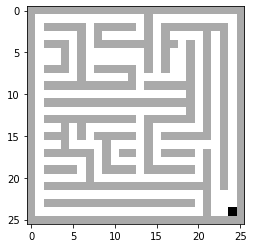

In [1161]:
plt.imshow(S, cmap='binary')

#### Define a utility function, s_next_calc, which computes the index of the next state given current state and action:

In [1162]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: action taken by the agent
    : returns: New state coordinates in the grid
    '''
    
    return (s[0] + A[a][0], s[1] + A[a][1])

#### Define a utility function to check if the action at current state leads to a collision with a wall:

In [1163]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE-1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==0 and S[s_new]==1):
        return True

    return False

#### Define the reward function:

In [1164]:
def R(s, a):
    '''Reward function
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return 0
    elif hit_wall(s, a):
        return -10000
    else:
        return -1

#### Calculate the transition probabilities to state s_next from current state s upon action a:

In [1165]:
def Pr(s_next, s, a, alpha):
    '''This function returns probabilities for each action at agent's
    current state.
    :param s: Current state of the agent
    :param a: Action the agent takes at the current state
    :param alpha: Probability of the agent to take a random action instead of the action a
    :returns : Transition probability for the action at current state
    '''
    # can't move once reached the GOAL
    if s == GOAL:
        if s_next == s:
            return 1
        else:
            return 0

    # If wall hit, next state is current state
    if hit_wall(s, a):
        # Illegal action with s = s'
        if s_next == s:
            return 1
        # Illegal action with s != s'
        else:
            return 0

    # Legal action with adjacent s and s'
    if s_next == s_next_calc(s, a):
        return 1 - alpha
    else:
        # Agent moves to another adjacent state instead of s' due to noise in a
        # Generate all other neighbors of s by applying actions other than a
        other_s_next = [s_next_calc(s, i)
                    for i in range(len(A)) if i is not a]
        if s_next in other_s_next:
            return alpha/4
    return 0

## Policy Iteration

In policy iteration, we define three functions:

* policy_evaluation
* policy_improvement
* policy_iteration


In [1166]:
def policy_evaluation(policy, S, Pr, alpha, discount, theta, ctr):
    
    V = np.zeros((GRID_SIZE, GRID_SIZE))
    V_prev = np.zeros((GRID_SIZE, GRID_SIZE))
 
    for _ in range(ctr):
        # chose an initial delta value for the convergence test
        delta = 0
        V_prev = V.copy()
        for s, _ in np.ndenumerate(S):
            if S[s] == 1:
                continue
            # action by the policy
            a = policy[s]
            # update value function for the state s  
            s_nex=[]
            for a1 in range(len(A)):
                if not hit_wall(s, a1): 
                    s_n = s_next_calc(s, a1)
                    s_nex.append(s_n)
            V[s] = R(s, a) + discount * sum(Pr(s_next, s, a, alpha) * V[s_next] for s_next in s_nex)
            # convergece test  
            delta = max(delta, abs(V[s] - V_prev[s]))
                            
        if delta < theta: break
        #print(policy[s])
        #print(s)
    
    return V, delta

In [1167]:
def policy_improvement(V, S, A, Pr, alpha, discount):
    
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    policy_stable = True
        
    for s, _ in np.ndenumerate(S):
        if S[s]==1:
            continue
        old_action = policy[s]
        Q = np.zeros(len(A))
        for a in range(len(A)):
            s_nex = []
            for a1 in range(len(A)):
                if not hit_wall(s, a1): 
                    s_n = s_next_calc(s, a1) 
                    s_nex.append(s_n)
            # update Q function at state, s, and action, a
            Q[a] = R(s, a) + discount * sum(Pr(s_next, s, a, alpha) * V[s_next] for s_next in s_nex)

            # update policy at state s
            policy[s] = np.argmax(Q)


        if old_action != policy[s]: policy_stable = False
    
    return policy, policy_stable

In [1168]:
def policy_iteration(S, A, Pr, alpha, discount, theta, n_eval, plot_enable, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: noise 
    :param float discount: discount factor
    :param float theta: tolerance, which determines when to end iterations
    :param int n_eval: number of evaluations
    :param plot: list of iteration numbers to plot
    """
    
    epsilon = 0
    
    # For Task 4 ######
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    ###################
    
    plt.ion()
    policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE))
    count=0
    
    while True:
                
        start_time = datetime.datetime.now() # For Task 4
        
        V, delta = policy_evaluation(policy, S, Pr, alpha, discount, theta, n_eval)
        policy , policy_stable = policy_improvement(V, S, A, Pr, alpha, discount)
        #print(V.shape)
        #print(policy.shape)
        
        # For Task 4
        end_time = datetime.datetime.now()
        time = (end_time - start_time).total_seconds() # calculate time taken [seconds] for one iteration
        total_time += time
      

        # plot intermediate result
        if (plot and count+1 in plot) and plot_enable:
            plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
        
        if delta == 0:
            if plot_enable :
                plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break
                
        if (delta > 0 and delta<=epsilon) or count==max_it or policy_stable:    
            if(count == max_it):
                print('Policy iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                 plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break
        count=count+1

    return V, policy, count, total_time


## Value Iteration

We use the following function for value iteration.

In [1169]:
def value_iteration(S, A, Pr, alpha, discount, plot_enable, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: noise
    :param float discount: discount factor
    """
    # For Task 4 ######
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    ###################
    
    plt.ion()

    V = np.zeros((GRID_SIZE, GRID_SIZE))
    V_prev = np.zeros((GRID_SIZE, GRID_SIZE))
    optimal_policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE), dtype=int)

    count=0
    while True:
        
        start_time = datetime.datetime.now() # For Task 4
    
        delta = 0 
        V_prev = V.copy()
        
        for s,_ in np.ndenumerate(S):
            #Check
            if S[s]==1:
                continue    
            Q = np.zeros(len(A))
            for a in range(len(A)):
                s_nex = []
                for a1 in range(len(A)):
                    if not hit_wall(s, a1): 
                        s_n = s_next_calc(s, a1) 
                        s_nex.append(s_n)
                    
                Q[a] = R(s, a) + discount * sum(Pr(s_next, s, a, alpha) * V[s_next] for s_next in s_nex)# expression for the Q function at state, s, and action, a
            V[s] = max(Q) 
            delta = max(delta, abs(V[s] - V_prev[s])) # set the validation condition for the convergence
            #print(delta)
            
            optimal_policy[s] = np.argmax(Q)
        
        # For Task 4
        end_time = datetime.datetime.now()
        time = (end_time - start_time).total_seconds() # calculate time taken [seconds] for one iteration
        total_time += time
        

        # plot current value and optimal policy
        if (plot and count+1 in plot) and plot_enable:
            plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            plt.pause(0.1)
        if delta <= 0 or count==max_it: 
            if count == max_it:
                print('Value iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
                plt.pause(0.1)
            break
        count=count+1
    return V, optimal_policy, count, total_time


#### We will use the following utility function to plot the grid with values from V:

In [1170]:
def plot_value_grid(V, policy, msg=""):
    fig = plt.figure(figsize=(5, 5), tight_layout=True)
    plt.title(msg)
    plt.imshow(V)
   
    quiver_action_dict = [
            [1, 0],
            [-1, 0],
            [0, -1],
            [0, 1],
            [0, 0]
    ]
    for k, a in np.ndenumerate(policy):
        if(S[k] == 0): # do not print the arrows on walls, to increase readibility
            q = plt.quiver(k[1], k[0], quiver_action_dict[a][1], quiver_action_dict[a][0])
    #fig.colorbar(q)
    plt.show()

## Tasks
### A. Find the optimal solution by two methods for  $\alpha$ = 0 (no noise).

### I. Policy Iteration 

We are using iterative policy evaluation.

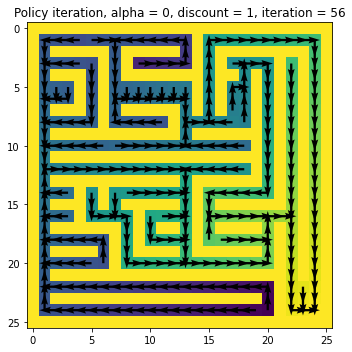

In [1171]:
n_pol_eval = 100 #number of policy evalutions
val2, pol2, pol_max_iter, time_taken = policy_iteration(S, A, Pr, alpha=0, discount=1, theta = 1e-6, n_eval=n_pol_eval, plot_enable = True)


### II. Value Iteration

Run for 100 iterations. 
Plot the value function and the optimal policy, at iterations 1, 25, 50, 100.

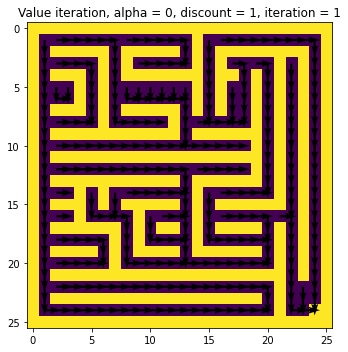

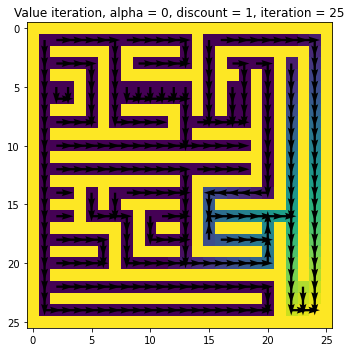

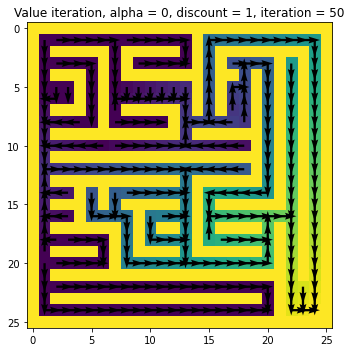

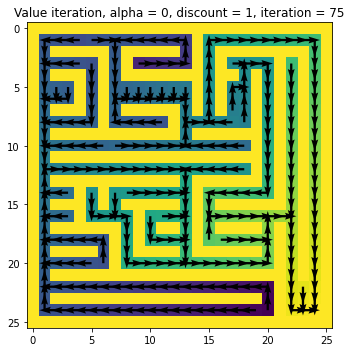

In [1172]:

val1, pol1, val_max_iter, time_taken = value_iteration(S, A, Pr, alpha=0, discount=1, plot_enable=True, plot=[1, 25, 50, 100])


Let's visualize these results

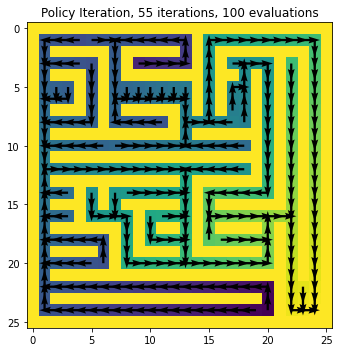

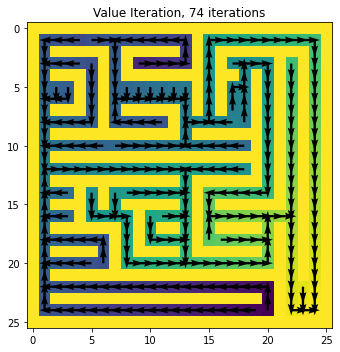

In [1173]:
# Plot for policy iteration alpha = 0, k_max = 100, run for 100 iterations
plot_value_grid(val2, pol2, msg='Policy Iteration, {} iterations, {} evaluations'.format(pol_max_iter, n_pol_eval))
# Plot for value iteration alpha = 0, 100 iterations
plot_value_grid(val1, pol1, msg='Value Iteration, {} iterations'.format(val_max_iter))

### III. Run Policy Iteration and Value Iteration for  five different discounted factors $\gamma \in \{0, 0.1, 0.4, 0.9, 1\}$ 

#### Policy iteration for 𝛾∈{0,0.1,0.4,0.9,1} :

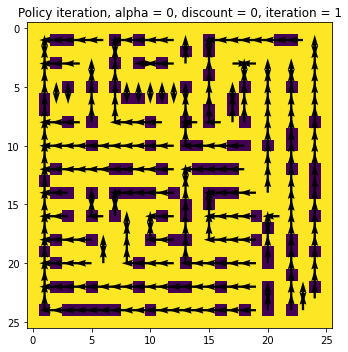

Policy iteration failed to converge for alpha = 0, discount = 0.1, iteration = 101


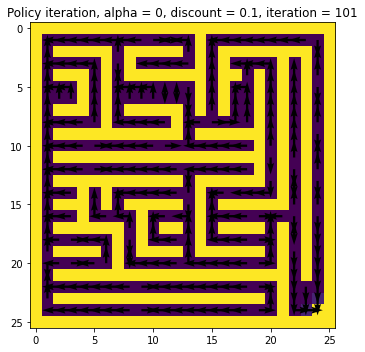

Policy iteration failed to converge for alpha = 0, discount = 0.4, iteration = 101


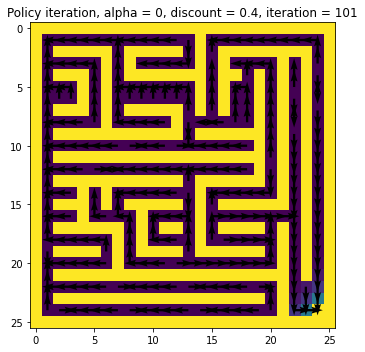

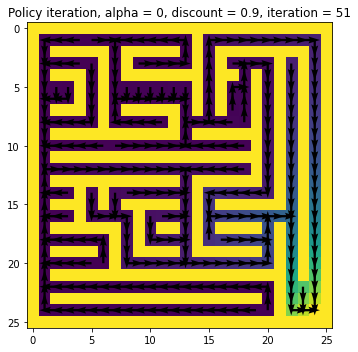

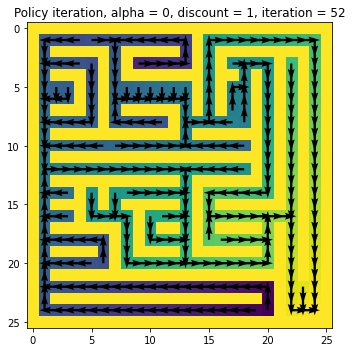

In [1174]:
n_pol_eval = 100 #number of policy evalutions
pol_time_list = []
for gamma in [0,0.1,0.4,0.9,1] :  
    val2, pol2, pol_max_iter, comp_time = policy_iteration(S, A, Pr, alpha=0, discount=gamma, theta=1e-6, n_eval=n_pol_eval, plot_enable = True)
    pol_time_list.append(comp_time)
    plt.pause(0.1)

#### Value iteration for 𝛾∈{0,0.1,0.4,0.9,1} :

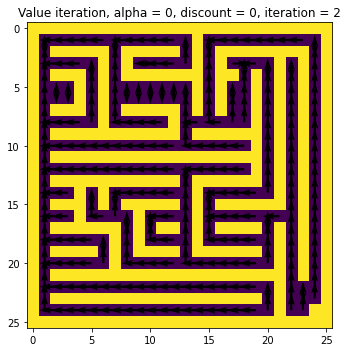

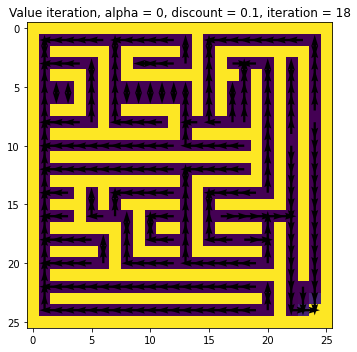

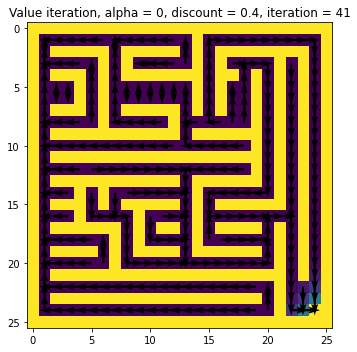

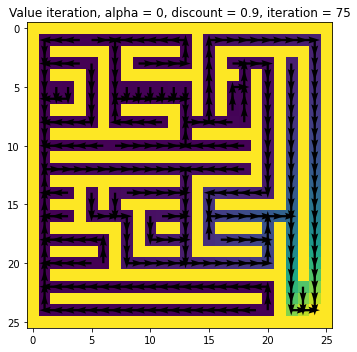

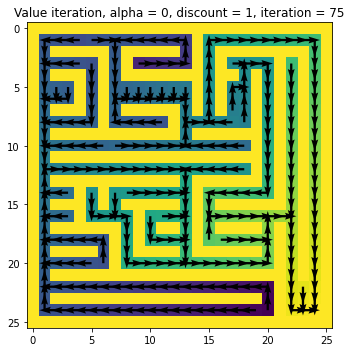

In [1175]:
n_pol_eval = 100 #number of policy evalutions
val_time_list = []
for gamma in [0,0.1,0.4,0.9,1] :
    val1, pol1, val_max_iter, comp_time = value_iteration(S, A, Pr, alpha=0, discount=gamma, plot_enable=True, plot=None)
    val_time_list.append(comp_time)
    plt.pause(0.1)

#### Explanations:

For Alpha = 0, no noise

    1)For policy iteration the model takes 56 iterations,

    2)For value iteration the model is iterated 1 25, 50 and 100 times, the model here stops as it has converged at the 75th iteration itself

When we plot both of them together and find that policy iteration takes 52 iteration to converge while value iteration takes 75 iteration to converge

We then run the script by changing for both policy and value iteration
Policy iteration

           1)Discounted factor = 0: The model doesn't converge nor reach the goal state, no of iteration is 1
           
           2)Discounted factor = 0.1: The model does reach the goal state but fails to converge, no of iteration is 101
           
           3)Discounted factor = 0.4: The model does reach the goal state but fails to converge, no of iteration is 101
           
           4)Discounted factor = 0.9: The model does reach the goal state and also converges, number of iterations 51
           
           5)Discounted factor = 1: The model does reach the goal state and also converges, number of iterations 52


Value iteration

           1)Discounted factor = 0: The model does not reach the goal state, no of iteration is 2
           
           2)Discounted factor = 0.1: The model does reach the goal state, no of iteration is 18
           
           3)Discounted factor = 0.4: The model does reach the goal state no of iteration is 41
            
           4)Discounted factor = 0.9: The model does reach the goal state, number of iterations 75
            
           5)Discounted factor = 1: The model does reach the goal state, number of iterations 75

Here we observe that for low Discounted factor the agent gave priority to immediate rewards instead of future rewards and on increasing the Discounted factor we observe that the model started giving more and more importance to future rewards


### IV. Plot $\gamma$ VS computational time for the given $\gamma$ 's

#### 𝛾 VS computational time for Policy iteration :

Text(0.5, 1.0, 'Discount VS Computational time for Policy iteration')

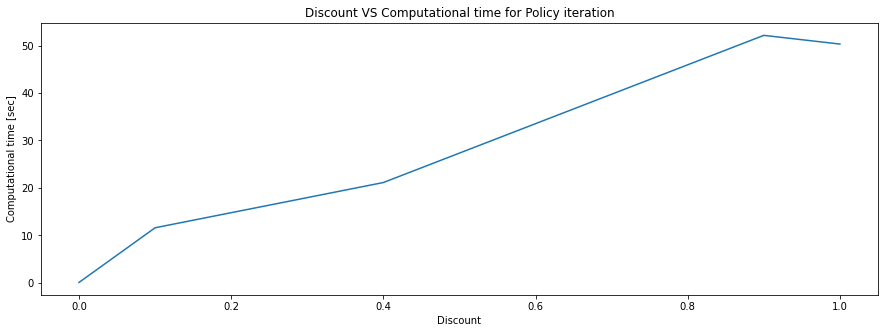

In [1176]:
fig = plt.figure(figsize=(15,5))

plt.xlabel('Discount')
plt.ylabel('Computational time [sec]')
plt.plot([0,0.1,0.4,0.9,1], pol_time_list)
plt.title('Discount VS Computational time for Policy iteration')

#### 𝛾 VS computational time for Value iteration :

Text(0.5, 1.0, 'Discount VS Computational time for Value iteration')

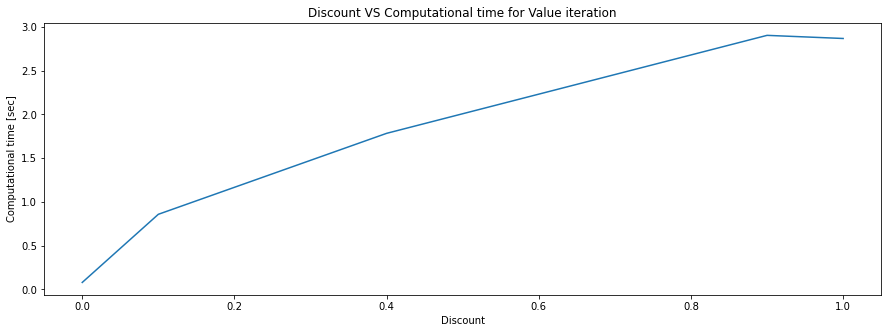

In [1177]:
fig = plt.figure(figsize=(15,5))

plt.xlabel('Discount')
plt.ylabel('Computational time [sec]')
plt.plot([0,0.1,0.4,0.9,1], val_time_list)
plt.title('Discount VS Computational time for Value iteration')

### B. Repeat Value and Policy iteration for 10, 20 and 100 iterations with $\alpha \in \{0.2, 0.8\}$

#### I. Policy Iteration 

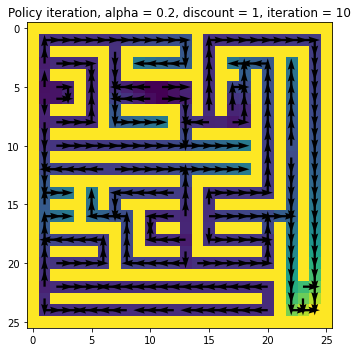

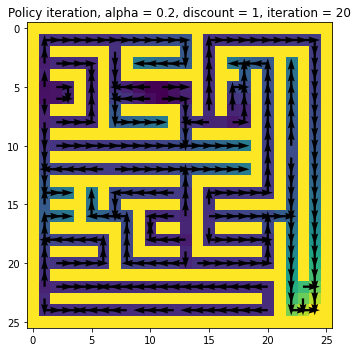

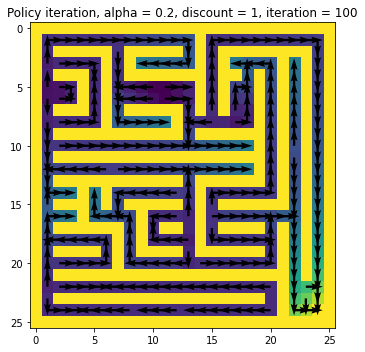

Policy iteration failed to converge for alpha = 0.2, discount = 1, iteration = 101


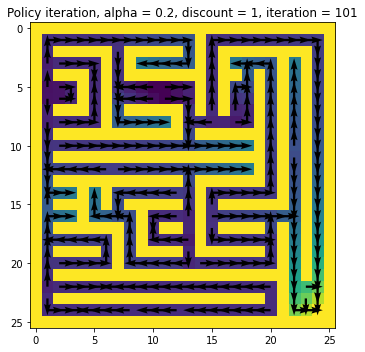

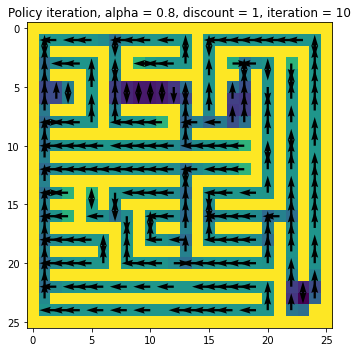

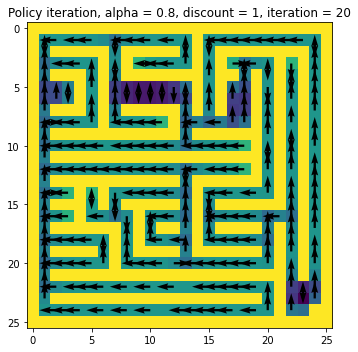

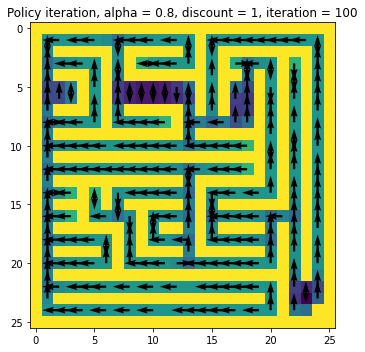

Policy iteration failed to converge for alpha = 0.8, discount = 1, iteration = 101


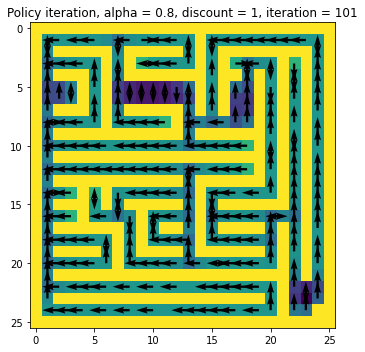

In [1178]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, pol_iter, time_taken = policy_iteration(S, A, Pr, alpha=alpha, discount = 1, theta=1e-6, n_eval=100, plot_enable = True, plot=[10, 20, 100])
    

#### II. Value Iteration

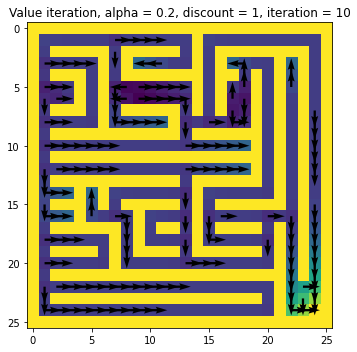

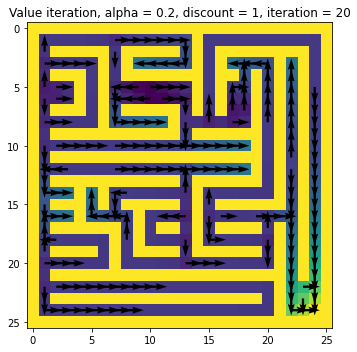

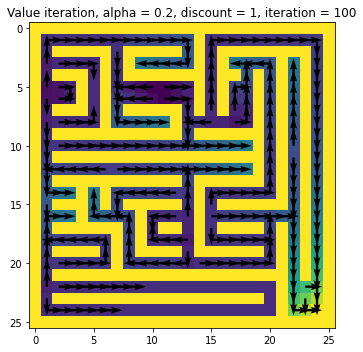

Value iteration failed to converge for alpha = 0.2, discount = 1, iteration = 101


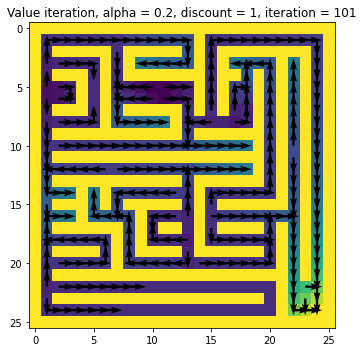

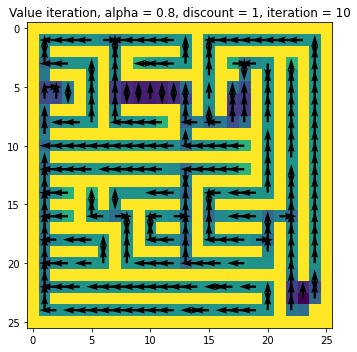

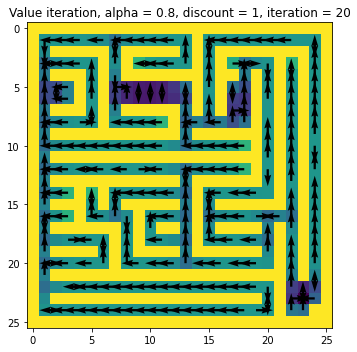

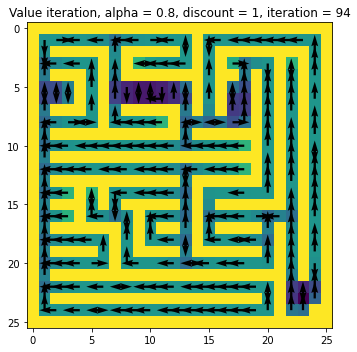

In [1179]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, val_iter, comp_time = value_iteration(S, A, Pr, alpha = alpha, discount = 1, plot_enable=True, plot=[10, 20, 100])
    

When noise is introduced we observe the following for policy iteration

We iterate the agent 10, 20 and 100 times for 0.2 noise,
We observe that for all iterations the agent does reach the goal state

But when the noise was 0.8 the agent did not go to the goal state at all infact it did the opposite and retreated to the initial state, this indicates that when we have a high nosie it affects the actions taken by agent and Cleary influences them

As for value iteration we did the same by iterating it 10, 20 and 100 times with noise as 0.2,  we observe that as the number of iteration increases the agent does more traversing and it does reach the goal state

As for 0.8 the agent goes haywire and doesnt even attempt to go to the goal state the reason being that for high noise the agent doesn't take optimal action.


The difference between a star and value and policy iteration


The differences that were observed include

1)A* followed the process of reaching the goal using the shortest path while value and policy iteration naviagted through the maze and tried to maximize the cumulative rewards

2) A star does not take sequence of actions in consideration while value/ policy does

3) A star focuses on finding optimal path to reach the goal while value/policy tends to focus on sequential decisions and gaining maximum rewards 

## <h1><center> Part-2 </center></h1>

#### <h1><center> Utility functions to be implemented / PSEUDOCODE </center></h1>

Action space: Same as Part-1.
<br>
State space: Design a 10x10 maze with 3 obstacles (an obstacle is a fence with a few blocks of "wall"). You can use the get_maze() function from Part-1.
<br><br>
dS - size of the maze with dimensions: dS x dS 
<br>
dA - number of actions
<br>
Goal - goal state.
<br><br>

PSEUDOCODE: function validState(s) =  returns true if (state, s, is within the maze boundaries) AND (s is NOT in the obstacles)

PSEUDOCODE: function BuildMaze(dS, dA, Goal):
<br>

	# dynamics tensor with dimensions: |dS| x |dS| x |dA| x |dS| x |dS| x 1, where the 
	# dimensions are S₁, S₂, A, S₁′, S₂′. e.g., S₂ is the current second coordinate of the state, and S₁′ is the first coordinate of the state at the next time step. 
	Ps′_sa = zeros(dS, dS, dA, dS, dS)

	# the reward tensor with the same dimension as the dynamics
	# reward is 0 at the Goal state, -10000 if agent hits the wall, and -1 elsewhere.
	Rs′sa  = -ones(dS, dS, dA, dS, dS)

	# iterate over the valid states
	for s in filter(validState, (x->x.I).(CartesianIndices((dS, dS))))
		if s ∈ Goal
			Ps′_sa[s..., :, s...] .= 1.0 # all the actions get prob 1 at the goal 
			Rs′sa[s..., :, s...]  .= 0.0 # all the actions get reward 0
			continue
		end

		for a in Actions # the same action set at each state 
			# if "next state is valid" move to it, otherwise stay at place 
			s′ = validState(s .+ a[2]) ? s .+ a[2] : s 
			Ps′_sa[s..., a[1], s′...] = 1.0
		end 
	end
	"sanity test:" forall a, s : sum_s′ Ps′_sa = 1 
	return Ps′_sa, Rs′sa
end


#### <h1><center> TASKS </center></h1>

### Placeholder for the definition of global variables, functions, etc

In [1180]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime
import random
%matplotlib inline


In [1181]:
def get_maze(maze_file):
    '''
    para1: filename of the maze txt file
    return mazes as a numpy array walls: 0 - no wall, 1 - wall
    '''
    a = open(maze_file, 'r')  
    m=[]
    for i in a.readlines():
        m.append(np.array(i.split(" "), dtype="int32"))
    return np.array(m)

### Task 1 ###
Maze with dimensions 10x10 and 3 fences, and the goal state (exit)
in one of the corners of the maze. Visualize the maze layout on 2D plot.

In [1182]:
# State Space
S=get_maze("maze_10x10.txt")
START = (1,1)
GOAL = (9,9)
# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]


# Noise
ALPHA = [0.2, 0.8]

max_it = 100

In [1183]:
#GRID_SIZE = len(dS)
dS=len(S)
# goal state
#Rand=(2,3)
S[GOAL] = 3
#dS[Rand]=3
#print(GOAL)

In [1184]:
print(S)

[[1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 1]
 [1 0 1 1 1 1 1 1 1 0 1]
 [1 0 1 0 0 0 0 0 0 0 1]
 [1 0 1 1 1 0 1 1 1 0 1]
 [1 0 0 0 1 0 0 0 0 0 1]
 [1 1 1 0 1 0 1 1 1 1 1]
 [1 0 0 0 1 0 1 0 0 0 1]
 [1 0 1 1 1 0 1 0 1 0 1]
 [1 0 0 0 0 0 0 0 0 3 1]
 [1 1 1 1 1 1 1 1 1 1 1]]


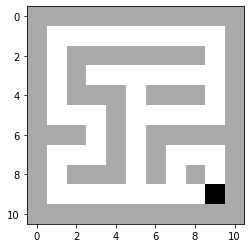

In [1185]:
plt.imshow(S, cmap='binary')

In [1186]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: action taken by the agent
    : returns: New state coordinates in the grid
    '''
    
    return (s[0] + A[a][0], s[1] + A[a][1])

In [1187]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE-1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==0 and S[s_new]==1):
        return True

    return False

### Task 2 ###
Implement the Policy Evaluation (PE) algorithm for a deterministic policy, π. 
<br>
The dimensions of the policy π[a | s] are |dS| x |dS| x |dA| x 1 x 1 x 1.
<br>
There is a single possible action at every state. 
<br>
E.g., π[UP | some_state] = [1, 0, 0, 0, 0], see 'Actions' above. 
<br>
E.g., π[Stay | another_state] = [0, 0, 0, 0, 1], see 'Actions' above. 
<br><br>
Evaluate a random deterministic policy, π.  Plot Value of a random policy on 2D plot. 
<br><br>
Instructions:
<br>
The policy is stationary, which means π[a′ | s′] is permute_dimensions(π[a | s], dim1->dim4, dim2->dim5, dim3->dim6)
<br>
Use broadcasting '.*', e.g.,
<br>
p(s′ a′ | s, a) = π[a′|s′] .* p(s′ | s, a)
<br>
sum_s′p(s′ | s, π[a|s]) .* V[s′], where V[s′] is the value of the next state with dimensions 1 x 1 x 1 x dS x dS x 1.
<br>
The value of the current state has dimensions dS x dS x 1 x 1 x 1 x 1. 
"V of the next state" is permute_dimensions("V of the current state", dims1->dims4, dims2->dims5)

In [1188]:
def BuildMaze(dS, A, GOAL):
    dA=len(A)
    Rs_sa = np.ones((dS, dS, dA, dS,dS), dtype=float) * -1  
    Ps_sa = np.zeros((dS, dS, dA, dS,dS), dtype=float)

    for s in np.ndindex((dS, dS)):
    
        if s == GOAL:
            Ps_sa[s[0], s[1], :, s[0], s[1]] = 1
            Rs_sa[s[0], s[1], :, s[0], s[1]] = 0  # Reward is 0 at the Goal state
        else:
            if (S[s]==1):
                Rs_sa[s[0], s[1], :, :, :] = -10000  # Reward is -10000 if agent hits the wall
                continue

        for a in range(len(A)):
            if not hit_wall(s, a):
                s_next = s_next_calc(s,a)
                Ps_sa[s[0], s[1], a, s_next[0], s_next[1]] = 1
            else:
                s_next = s_next_calc(s,a)
                Ps_sa[s[0], s[1], a, s[0], s[1]] = 1
                Rs_sa[s[0], s[1], a, s[0], s[1]] = -10000

    return Ps_sa, Rs_sa

In [1189]:
def policy_Optpolicy(dS,S,A):
    dA=len(A)
    policy = np.zeros((dS, dS, dA, 1, 1), dtype=float)
    optimal_policy = np.zeros((dS, dS), dtype=int)
    for s in np.ndindex((dS, dS)):
        randomizer = random.choice(range(dA))
        optimal_policy[s[0], s[1]] = int(randomizer)
        policy[s[0], s[1], randomizer, :, :] = 1
    return policy,optimal_policy   

In [1190]:
def plot_value_grid(V, policy, msg=""):
    fig = plt.figure(figsize=(5, 5), tight_layout=True)
    plt.title(msg)
    plt.imshow(V)
   
    quiver_action_dict = [
            [1, 0],
            [-1, 0],
            [0, -1],
            [0, 1],
            [0, 0]
    ]
    for k, a in np.ndenumerate(policy):

        if(S[k] == 0): # do not print the arrows on walls, to increase readibility
            q = plt.quiver(k[1], k[0], quiver_action_dict[a][1], quiver_action_dict[a][0])
    #fig.colorbar(q)
    plt.show()

In [1191]:
def policy_evaluation(policy,Ps_sa,Rs_sa,dS,discount,ctr,theta):

    
    V = np.zeros((dS, dS, 1, 1, 1), dtype=float)
    for _ in range(ctr):
        delta=0
        V_prev = V.copy()
        Vi = np.sum(policy * (Ps_sa * (Rs_sa + discount * V_prev.transpose((3, 4, 2, 0, 1)))), axis=(2, 3, 4))
        V = Vi.reshape((dS, dS, 1, 1, 1))
        
        delta = np.max(np.abs(V.squeeze() - V_prev.squeeze()))
        #print(delta)                  
        if delta < theta:
            break           
    return V,delta
    

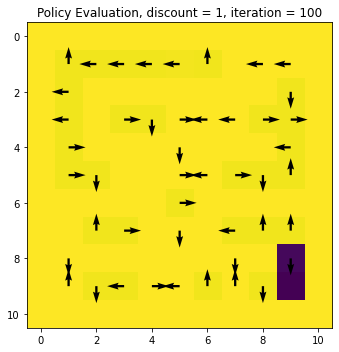

In [1192]:
Ps_sa,Rs_sa = BuildMaze(dS,A,GOAL)
policy,optimal_policy =policy_Optpolicy(dS,S,A)
n_pol_eval =100
discount=1
V,delta=policy_evaluation(policy,Ps_sa,Rs_sa,dS,discount,n_pol_eval,theta = 1e-6)

plot_value_grid(V.squeeze(), optimal_policy, msg='Policy Evaluation, discount = {}, iteration = {}'.format(1, n_pol_eval))

### Task 3 ###
Repeat Task 2 with manually setting the optimal actions in the radius of 2 states from the goal state.
Explain your observations.

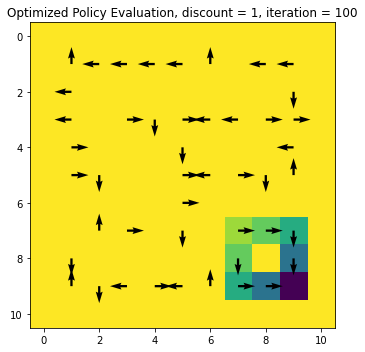

In [1193]:
#optimizing policy
policy[9,8,:,:,:]=0
policy[9,8,3,:,:]=1
optimal_policy[9,8]=3
policy[8,9,:,:,:]=0
policy[8,9,1,:,:]=1
optimal_policy[8,9]=1
policy[7,8,:,:,:]=0
policy[7,8,3,:,:]=1
optimal_policy[7,8]=3
policy[7,7,:,:,:]=0
policy[7,7,3,:,:]=1
optimal_policy[7,7]=3
policy[7,9,:,:,:]=0
policy[7,9,1,:,:]=1
optimal_policy[7,9]=1
policy[8,7,:,:,:]=0
policy[8,7,1,:,:]=1
optimal_policy[8,7]=1
policy[9,7,:,:,:]=0
policy[9,7,3,:,:]=1
optimal_policy[9,7]=3
V,delta=policy_evaluation(policy,Ps_sa,Rs_sa,dS,discount,n_pol_eval,theta = 1e-6)
plot_value_grid(V.squeeze(), optimal_policy, msg='Optimized Policy Evaluation, discount = {}, iteration = {}'.format(1, n_pol_eval))

Manually setting optimal actions within a radius of 2 states from the goal state implies that we are modifying the policy in a way that is has efficient paths to the goal.
This change should result in a modified value function that reflects the improved policy.

In [1194]:
def policy_improvement(V,policy,Ps_sa,Rs_sa,dS,discount,optimal_policy):
    
    Q = np.zeros((dS,dS,len(A),1,1))

    Q = np.sum((Ps_sa * (Rs_sa + discount * V.transpose((3, 4, 2, 0, 1)))), axis=(3, 4))
    
    OP_policy = np.argmax(Q, axis=2)
    
    policy = np.eye(len(A))[OP_policy].reshape((x_c, y_c,len(A), 1, 1))
    
    stable_policy = np.array_equal(OP_policy, optimal_policy) 
    
    optimal_policy = OP_policy.copy()
    
    return policy,optimal_policy,stable_policy

In [1195]:
def policy_iteration(dS, A, Ps_sa, Rs_sa, discount, n_eval,optimal_policy,policy,theta,plot=None):
    plt.ion()
    max_it=100
    count=0        
    while True:
            
        #policy = np.zeros((x_c,y_c,len(A),1,1))
        V,delta = policy_evaluation(policy,Ps_sa,Rs_sa,dS,discount,n_eval,theta)
        policy,optimal_policy,stable_policy  = policy_improvement(V, policy,Ps_sa,Rs_sa,dS,discount,optimal_policy)

        if delta < theta : #or stable_policy:
            print(f"The policy iteration has successfully converged after {count} iterations.")
            plot_value_grid(V.squeeze(), optimal_policy, msg='Converged Policy iteration, discount = {}, iteration = {}'.format(discount, count))
            plt.pause(0.1)
            break
        if count == n_eval or count in plot:
            print(f"The policy iteration, iterations= {count}.")
            plot_value_grid(V.squeeze(), optimal_policy, msg='Policy iteration, discount = {}, iteration = {}'.format(discount,count))
            plt.pause(0.1)

        if count == n_eval:
            print(f"'Policy iteration failed to converge after {count} iterations. The delta value = {delta}.")
            break
        count=count+1
    return V, policy
    

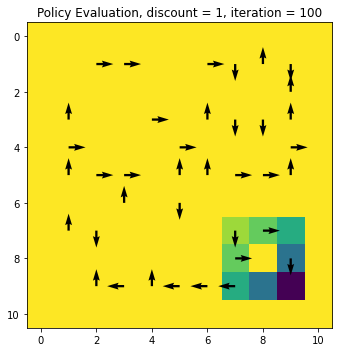

The policy iteration, iterations= 1.


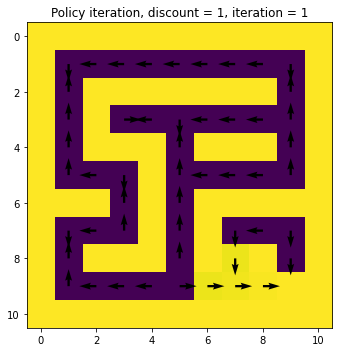

The policy iteration, iterations= 10.


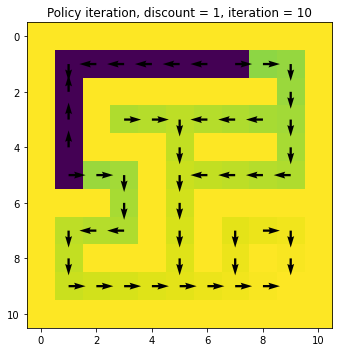

The policy iteration, iterations= 13.


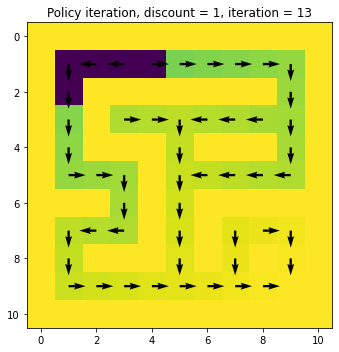

The policy iteration has successfully converged after 14 iterations.


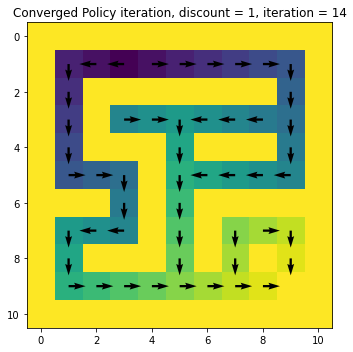

In [1197]:
Ps_sa,Rs_sa = BuildMaze(dS,A,GOAL)
policy,optimal_policy =policy_Optpolicy(dS,S,A)
n_pol_eval =100
discount=1
plot_value_grid(V.squeeze(), optimal_policy, msg='Policy Evaluation, discount = {}, iteration = {}'.format(1, n_pol_eval))
val2, pol2 = policy_iteration(dS,A,Ps_sa,Rs_sa,discount,n_pol_eval,optimal_policy,policy,theta = 1e-6,plot=[1,10,13])

#### Observations:

The difference that one observes in broadcasting approach is that there is not a lot of iterating resulting in lesser time complexity and a better optimized code.

Broadcasting by using tensors iterates over the whole array which results in code compiling faster.

The reason for this time difference is because broadcasting does not need explicit loops as seen above, where instead of going over all states one by one it does this in one go.

This also results in faster convergence than the earlier methods.